In [1]:
# Improved image loading with progress tracking
def load_image_data(folder_path, label, target_size=(32, 32)):
    images = []
    labels = []
    total_files = len(os.listdir(folder_path))
    print(f"Loading {total_files} images from {folder_path}...")
    
    for i, img_name in enumerate(os.listdir(folder_path)):
        img_path = os.path.join(folder_path, img_name)
        try:
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
            img = tf.keras.preprocessing.image.img_to_array(img)
            images.append(img)
            labels.append(label)
            
            # Print progress every 1000 images
            if (i+1) % 1000 == 0 or (i+1) == total_files:
                print(f"Loaded {i+1}/{total_files} images")
                
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            
    return np.array(images), np.array(labels)

In [2]:
def make_model(model, learning_rate=1e-3, optimizer="adam", batchsize=32, 
               noise_stddev=0.1, dropout_rate=0.5):
    efficientnet = model
    
    inputs = keras.Input(shape=(32, 32, 3))
    x = keras.layers.GaussianNoise(noise_stddev)(inputs)
    x = efficientnet(inputs, training=False)
    
    # Feature extraction
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(256, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)  # Added BatchNorm
    x = keras.layers.Dropout(dropout_rate)(x)
    
    # Additional dense layer
    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.Dropout(dropout_rate/2)(x)
    
    outputs = keras.layers.Dense(2, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    # Learning rate scheduler
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=learning_rate,
        decay_steps=10000,
        decay_rate=0.9)
    
    # Optimizer selection
    if optimizer.lower() == "adam":
        opt = keras.optimizers.Adam(learning_rate=lr_schedule)
    else:
        opt = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)
    
    model.compile(
        optimizer=opt,
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[
            keras.metrics.BinaryAccuracy(),
            keras.metrics.Precision(),
            keras.metrics.Recall()
        ])
    
    # Early stopping callback
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True)
    ]
    
    print('Training model...')
    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batchsize,
        epochs=10,
        validation_data=(X_val, y_val),
        callbacks=callbacks,
        verbose=1
    )
    
    return model, history

In [3]:
def evaluateModel(cnnModel):
    print("\nEvaluating model...")
    results = cnnModel.evaluate(X_val, y_val, verbose=0)
    print(f"Loss: {results[0]:.4f}")
    print(f"Accuracy: {results[1]:.4f}")
    print(f"Precision: {results[2]:.4f}")
    print(f"Recall: {results[3]:.4f}")
    
    y_pred = cnnModel.predict(X_val, verbose=0)
    y_pred_conv = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_val, axis=1)

    # Enhanced confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_true, y_pred_conv), 
                annot=True, fmt="d", 
                cmap="Blues",
                xticklabels=["REAL", "FAKE"], 
                yticklabels=["REAL", "FAKE"],
                annot_kws={"size": 16})
    plt.xlabel("Predicted Label", fontsize=14)
    plt.ylabel("True Label", fontsize=14)
    plt.title("Confusion Matrix", fontsize=16)
    plt.show()

    # Classification report with additional metrics
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_conv, target_names=["REAL", "FAKE"]))
    
    # Calculate additional metrics
    f1 = f1_score(y_true, y_pred_conv)
    recall = recall_score(y_true, y_pred_conv)
    precision = precision_score(y_true, y_pred_conv)
    
    print(f"\nF1 Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    
    return results

In [4]:
def make_plot(history):
    metrics = ['loss', 'binary_accuracy', 'precision', 'recall']
    
    plt.figure(figsize=(15, 10))
    
    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        
        # Plot training metric
        plt.plot(history.history[metric], label=f'Training {metric}')
        
        # Plot validation metric if it exists
        val_metric = f'val_{metric}'
        if val_metric in history.history:
            plt.plot(history.history[val_metric], label=f'Validation {metric}')
            
        plt.title(metric.upper())
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.legend()
        
    plt.tight_layout()
    plt.show()

In [5]:
def save_model(model, base_path='/kaggle/working'):
    # Create directory if it doesn't exist
    os.makedirs(base_path, exist_ok=True)
    
    # Save weights
    weights_path = os.path.join(base_path, 'AI_IMAGE_DETECTOR.weights.h5')
    model.save_weights(weights_path)
    
    # Save full model
    model_path = os.path.join(base_path, 'AI_IMAGE_DETECTOR_full_model.h5')
    model.save(model_path)
    
    # Save model architecture as JSON
    json_path = os.path.join(base_path, 'model_architecture.json')
    with open(json_path, 'w') as json_file:
        json_file.write(model.to_json())
    
    print(f"✅ Model saved successfully to {base_path}")
    print(f"- Weights: {weights_path}")
    print(f"- Full model: {model_path}")
    print(f"- Architecture: {json_path}")

In [6]:
def visualize_predictions(model, image_dir, num_images=10):
    image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir)[:num_images]]
    
    plt.figure(figsize=(20, 10))
    for i, img_path in enumerate(image_paths):
        # Load and preprocess image
        img = image.load_img(img_path, target_size=(32, 32))
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        
        # Predict
        pred = model.predict(img_array, verbose=0)[0]
        pred_class = np.argmax(pred)
        confidence = np.max(pred)
        
        # Display
        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        plt.title(f"Pred: {'FAKE' if pred_class == 0 else 'REAL'}\nConf: {confidence:.2f}",
                 color='green' if pred_class == 1 else 'red')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed predictions
    print("\nDetailed Predictions:")
    for i, img_path in enumerate(image_paths):
        img = image.load_img(img_path, target_size=(32, 32))
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        pred = model.predict(img_array, verbose=0)[0]
        print(f"{os.path.basename(img_path)}: {pred} → Class: {np.argmax(pred)} ({'FAKE' if np.argmax(pred) == 0 else 'REAL'})")

In [7]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, confusion_matrix
import os
import numpy as np
from keras import Sequential
from keras.layers import Dense, Input, MaxPool2D, Conv2D, Flatten, InputLayer, Reshape, Conv2DTranspose, BatchNormalization
# import kaggle
import zipfile
import torch
import joblib
import shap
import dill

c:\Users\MSI\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# 1. Define Constants and Paths (UPDATE THESE)
IMG_ROWS, IMG_COLS = 32, 32
TRAIN_PATH = r'/kaggle/input/deepfake-and-real-images/Dataset/Train'
TEST_PATH = r'/kaggle/input/deepfake-and-real-images/Dataset/Test'    # Replace with your path

# 2. Load and Prepare Data

In [9]:

print("Loading training data...")
real_images, real_labels = load_image_data(os.path.join(TRAIN_PATH, 'Real'), [0, 1])
fake_images, fake_labels = load_image_data(os.path.join(TRAIN_PATH, 'Fake'), [1, 0])


Loading training data...


FileNotFoundError: [WinError 3] The system cannot find the path specified: '/kaggle/input/deepfake-and-real-images/Dataset/Train\\Real'

In [10]:

print("Loading test data...")
test_real_images, test_real_labels = load_image_data(os.path.join(TEST_PATH, 'Real'), [0, 1])
test_fake_images, test_fake_labels = load_image_data(os.path.join(TEST_PATH, 'Fake'), [1, 0])

Loading test data...
Loading 5413 images from /kaggle/input/deepfake-and-real-images/Dataset/Test/Real...
Loaded 1000/5413 images
Loaded 2000/5413 images
Loaded 3000/5413 images
Loaded 4000/5413 images
Loaded 5000/5413 images
Loaded 5413/5413 images
Loading 5492 images from /kaggle/input/deepfake-and-real-images/Dataset/Test/Fake...
Loaded 1000/5492 images
Loaded 2000/5492 images
Loaded 3000/5492 images
Loaded 4000/5492 images
Loaded 5000/5492 images
Loaded 5492/5492 images


In [11]:


# Combine and normalize data
X_train = np.concatenate((real_images, fake_images)).astype('float32') / 255.0
y_train = np.concatenate((real_labels, fake_labels))
X_test = np.concatenate((test_real_images, test_fake_images)).astype('float32') / 255.0
y_test = np.concatenate((test_real_labels, test_fake_labels))

In [12]:
# Split into train/validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


In [13]:

# 3. Initialize Model
base_model = keras.applications.EfficientNetB0(
    include_top=False,
    weights=None,
    input_shape=(IMG_ROWS, IMG_COLS, 3)
)
base_model.load_weights('/kaggle/input/eff/tensorflow2/default/1/efficientnetb0_notop.h5')  # Replace with your weights path


I0000 00:00:1745404219.304076      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [14]:

# 4. Train Model
print("\nTraining model...")
trained_model, training_history = make_model(
    base_model,
    learning_rate=1e-3,
    optimizer="adam",
    batchsize=32,
    noise_stddev=0.1,
    dropout_rate=0.5
)


Training model...
Training model...
Epoch 1/10


I0000 00:00:1745404280.359034      57 service.cc:148] XLA service 0x7da950002f20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745404280.359546      57 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745404285.459571      57 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1745404292.548237      57 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745404292.725870      57 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


   3/3938 ━━━━━━━━━━━━━━━━━━━━ 1:43 26ms/step - binary_accuracy: 0.4514 - loss: 1.0829 - precision: 0.4514 - recall: 0.4514   

I0000 00:00:1745404313.881995      57 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3936/3938 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - binary_accuracy: 0.7380 - loss: 0.5353 - precision: 0.7380 - recall: 0.7380

E0000 00:00:1745404411.982663      59 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745404412.160109      59 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


3938/3938 ━━━━━━━━━━━━━━━━━━━━ 222s 34ms/step - binary_accuracy: 0.7381 - loss: 0.5353 - precision: 0.7381 - recall: 0.7381 - val_binary_accuracy: 0.8473 - val_loss: 0.3332 - val_precision: 0.8473 - val_recall: 0.8473
Epoch 2/10
3938/3938 ━━━━━━━━━━━━━━━━━━━━ 92s 23ms/step - binary_accuracy: 0.8631 - loss: 0.3153 - precision: 0.8631 - recall: 0.8631 - val_binary_accuracy: 0.8603 - val_loss: 0.3390 - val_precision: 0.8603 - val_recall: 0.8603
Epoch 3/10
3938/3938 ━━━━━━━━━━━━━━━━━━━━ 91s 23ms/step - binary_accuracy: 0.8761 - loss: 0.2890 - precision: 0.8761 - recall: 0.8761 - val_binary_accuracy: 0.8870 - val_loss: 0.2589 - val_precision: 0.8870 - val_recall: 0.8870
Epoch 4/10
3938/3938 ━━━━━━━━━━━━━━━━━━━━ 92s 23ms/step - binary_accuracy: 0.8957 - loss: 0.2485 - precision: 0.8957 - recall: 0.8957 - val_binary_accuracy: 0.8939 - val_loss: 0.2471 - val_precision: 0.8939 - val_recall: 0.8939
Epoch 5/10
3938/3938 ━━━━━━━━━━━━━━━━━━━━ 92s 23ms/step - binary_accuracy: 0.9053 - loss: 0.2272 -


Evaluating model...

Evaluating model...
Loss: 0.2244
Accuracy: 0.9078
Precision: 0.9078
Recall: 0.9078


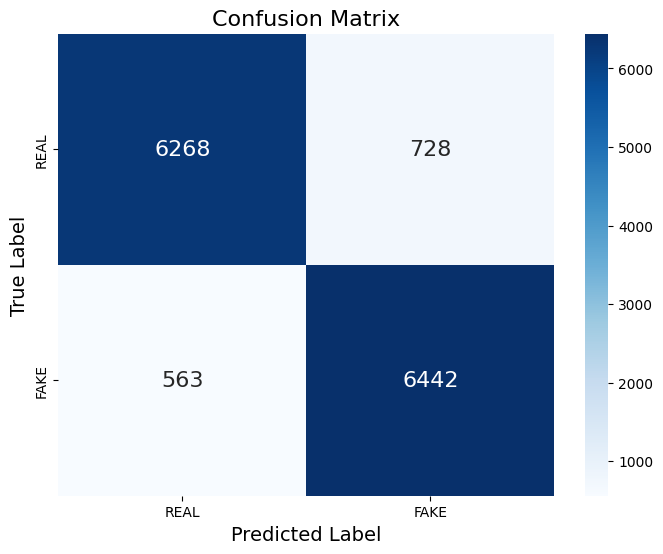


Classification Report:
              precision    recall  f1-score   support

        REAL       0.92      0.90      0.91      6996
        FAKE       0.90      0.92      0.91      7005

    accuracy                           0.91     14001
   macro avg       0.91      0.91      0.91     14001
weighted avg       0.91      0.91      0.91     14001


F1 Score: 0.9089
Recall: 0.9196
Precision: 0.8985


[0.22435152530670166, 0.907792329788208, 0.907792329788208, 0.907792329788208]

In [15]:
# 5. Evaluate Model
print("\nEvaluating model...")
evaluateModel(trained_model)


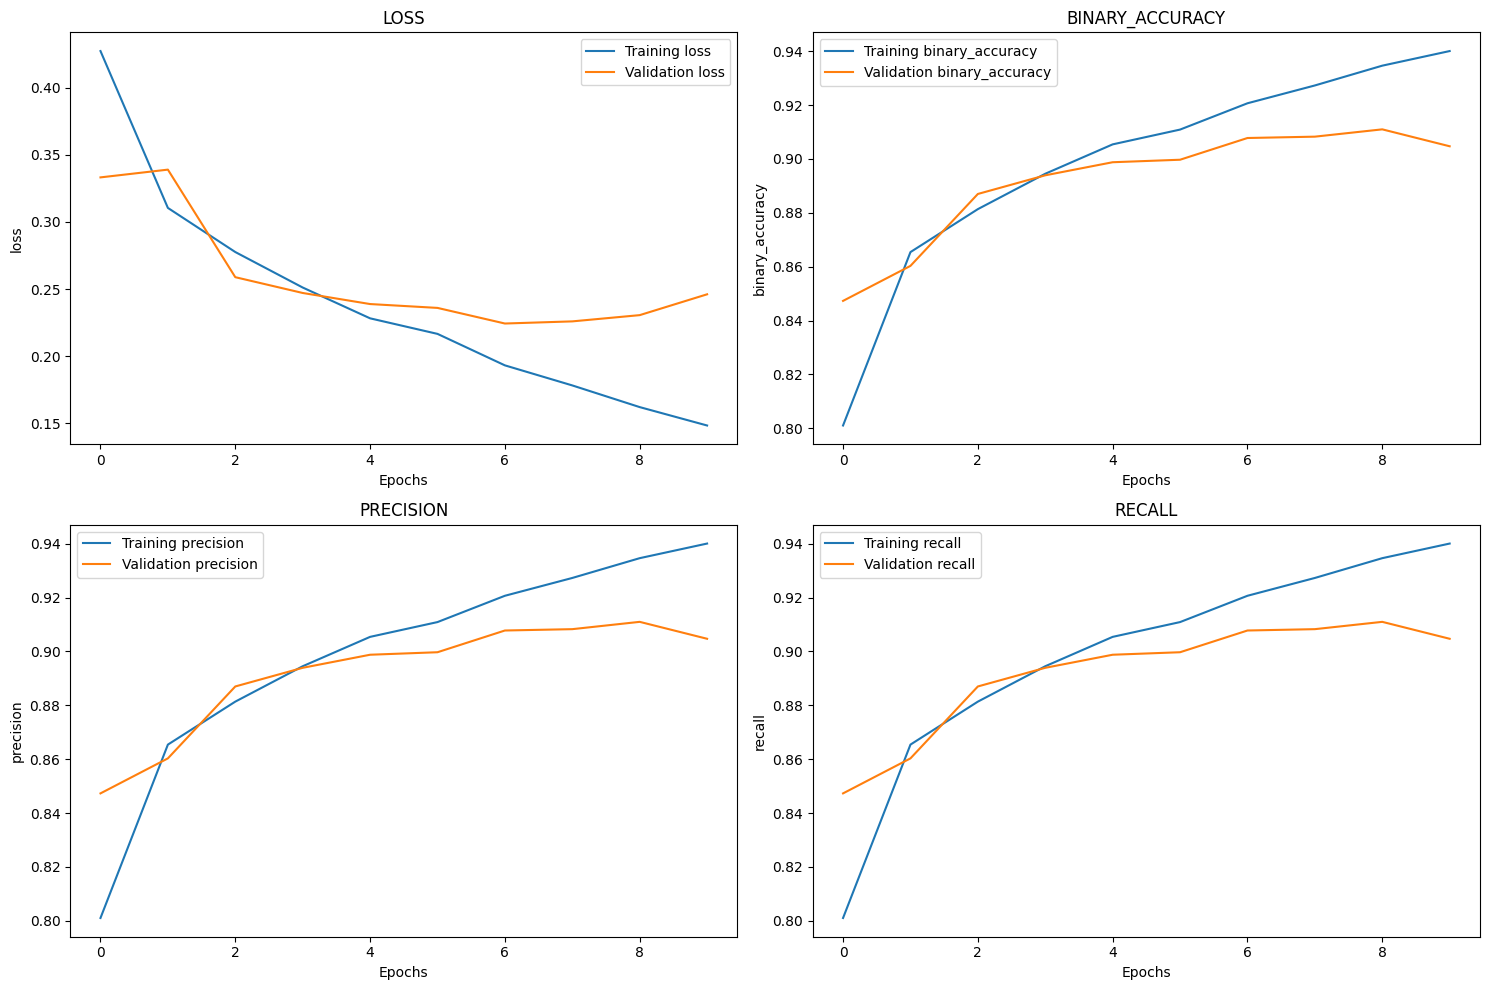

In [16]:

# 6. Visualize Training Progress
make_plot(training_history)


Running demo prediction...


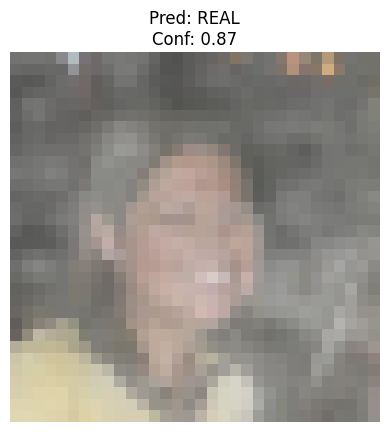

In [17]:
# 8. Demo Prediction (Optional)
from tensorflow.keras.preprocessing import image
demo_image_path = '/kaggle/input/deepfake-and-real-images/Dataset/Test/Real/real_100.jpg'  # Replace with your test image
if os.path.exists(demo_image_path):
    print("\nRunning demo prediction...")
    img = image.load_img(demo_image_path, target_size=(32, 32))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    pred = trained_model.predict(img_array, verbose=0)[0]
    pred_class = np.argmax(pred)
    confidence = np.max(pred)
    
    plt.imshow(img)
    plt.title(f"Pred: {'FAKE' if pred_class == 0 else 'REAL'}\nConf: {confidence:.2f}")
    plt.axis('off')
    plt.show()
else:
    print(f"\nDemo image not found at {demo_image_path}")


Testing model on sample images from /kaggle/input/deepfake-and-real-images/Dataset/Test...


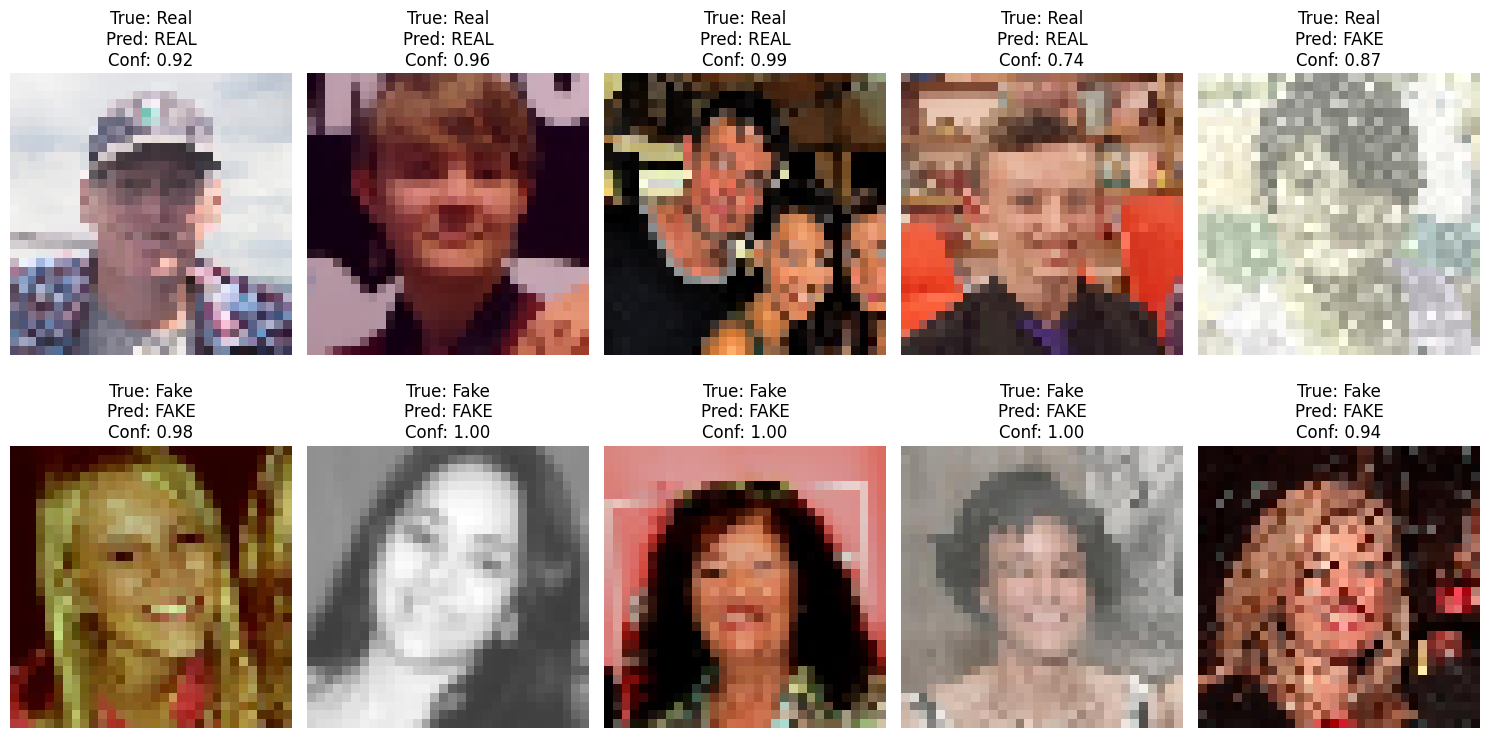

In [18]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os

# 8. Batch Prediction on Multiple Test Images
def test_multiple_images(model, test_dir, num_images=5, target_size=(32, 32)):
    """
    Test the model on multiple images from the test directory
    
    Args:
        model: Trained model
        test_dir: Path to test directory (should contain 'REAL' and 'FAKE' subfolders)
        num_images: Number of images to test from each class
        target_size: Size to resize images
    """
    plt.figure(figsize=(15, 8))
    
    for i, class_name in enumerate(['Real', 'Fake']):
        class_dir = os.path.join(test_dir, class_name)
        
        # Get first 'num_images' from the class directory
        image_files = [f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.png'))][:num_images]
        
        for j, img_file in enumerate(image_files):
            img_path = os.path.join(class_dir, img_file)
            
            # Load and preprocess image
            img = image.load_img(img_path, target_size=target_size)
            img_array = image.img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)
            
            # Make prediction
            pred = model.predict(img_array, verbose=0)[0]
            pred_class = np.argmax(pred)
            confidence = np.max(pred)
            
            # Plot results
            plt_idx = i * num_images + j + 1
            plt.subplot(2, num_images, plt_idx)
            plt.imshow(img)
            plt.title(f"True: {class_name}\nPred: {'FAKE' if pred_class == 0 else 'REAL'}\nConf: {confidence:.2f}")
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Usage example
TEST_PATH = '/kaggle/input/deepfake-and-real-images/Dataset/Test'
if os.path.exists(TEST_PATH):
    print(f"\nTesting model on sample images from {TEST_PATH}...")
    test_multiple_images(trained_model, TEST_PATH, num_images=5)
else:
    print(f"\nTest directory not found at {TEST_PATH}")


Testing model on sample images from /kaggle/input/personal/datset...

✅ Model Accuracy on Sample Test Set: 50.00%


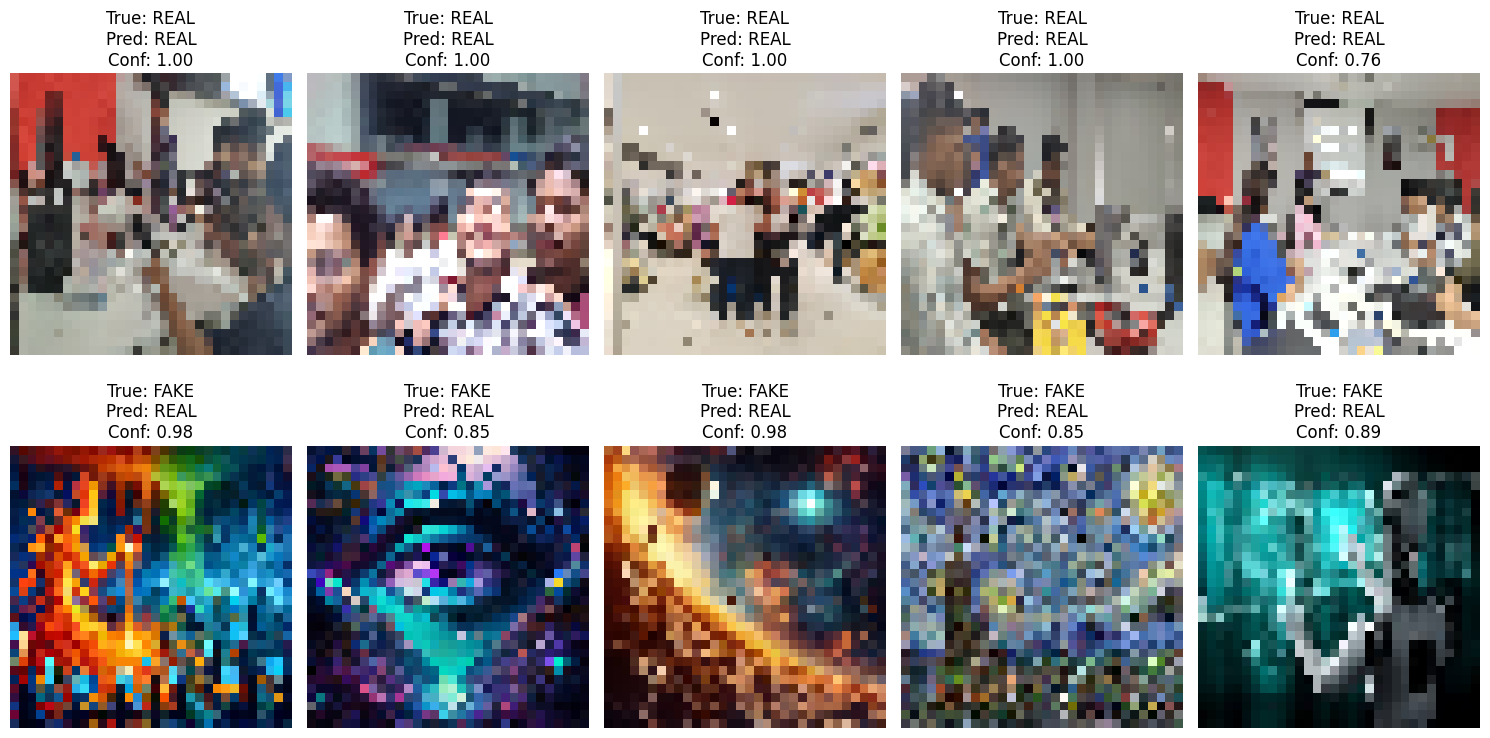

In [19]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os

def test_multiple_images(model, test_dir, num_images=8, target_size=(32, 32)):
    """
    Test the model on multiple images from the test directory
    
    Args:
        model: Trained model
        test_dir: Path to test directory (should contain 'Real' and 'Fake' subfolders)
        num_images: Number of images to test from each class
        target_size: Size to resize images
    """
    plt.figure(figsize=(15, 8))

    total = 0
    correct = 0
    
    class_map = {'REAL': 1, 'FAKE': 0}  # Map for label vs prediction

    for i, class_name in enumerate(['REAL', 'FAKE']):
        class_dir = os.path.join(test_dir, class_name)
        
        # Get first 'num_images' from the class directory
        image_files = [f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.png'))][:num_images]
        
        for j, img_file in enumerate(image_files):
            img_path = os.path.join(class_dir, img_file)
            
            # Load and preprocess image
            img = image.load_img(img_path, target_size=target_size)
            img_array = image.img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)
            
            # Make prediction
            pred = model.predict(img_array, verbose=0)[0]
            pred_class = np.argmax(pred)
            confidence = np.max(pred)
            
            # Accuracy Tracking
            true_class = class_map[class_name]
            total += 1
            if pred_class == true_class:
                correct += 1
            
            # Plot results
            plt_idx = i * num_images + j + 1
            plt.subplot(2, num_images, plt_idx)
            plt.imshow(img)
            plt.title(f"True: {class_name}\nPred: {'REAL' if pred_class == 1 else 'FAKE'}\nConf: {confidence:.2f}")
            plt.axis('off')

    # Print Accuracy
    accuracy = correct / total if total > 0 else 0
    print(f"\n✅ Model Accuracy on Sample Test Set: {accuracy * 100:.2f}%")

    plt.tight_layout()
    plt.show()


# Usage example
TEST_PATH = '/kaggle/input/personal/datset'

if os.path.exists(TEST_PATH):
    print(f"\nTesting model on sample images from {TEST_PATH}...")
    test_multiple_images(trained_model, TEST_PATH, num_images=5)
else:
    print(f"\n❌ Test directory not found at {TEST_PATH}")


In [20]:
trained_model.save_weights('/kaggle/working/AI_IMAGE_DETECTOR(DEEP).weights.h5')

# Save the full model (architecture + weights + optimizer)
trained_model.save('/kaggle/working/AI_IMAGE_DETECTOR_full_model(DEEP).h5')

print("✅ Weights and full model saved successfully.")

✅ Weights and full model saved successfully.
